# CoppeliaSim - CalcUABlator

## Import libraries:

In [1]:
import sim
import numpy as np
import cv2                             # opencv
import matplotlib.pyplot as plt        # pyplot
import time
import easyocr
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
import time
from sympy import *

## Establish the connection:

In [2]:
def connect(port):
# Establishes the connection to COPPELIA
# The port must match the connection port in COPPELIA -- PRESS PLAY in Coppelia Scene!!!
# returns the client number or -1 if the connection cannot be established
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("connect to ", port)
    else: print("Can not connect ")
    return clientID

# Connect to the COPPELIA server
# *** It must be executed every time the simulation is restarted ***
# Remember press PLAY before in coppelia scene
clientID = connect(19999)

connect to  19999


<h3> We get the handlers: </h3>
A handler is an identifier number that Coppelia assigns to each of the elements in the scene.

In [3]:
# We obtain the controllers for each of the robot's joints (Called joint1 and joint2 in the scenne)
retCode, joint1=sim.simxGetObjectHandle(clientID,'Joint_DC1',sim.simx_opmode_blocking)                  # DC1
retCode, joint2=sim.simxGetObjectHandle(clientID,'Joint_DC2',sim.simx_opmode_blocking)                  # DC2
retCode, joint3=sim.simxGetObjectHandle(clientID,'Joint_ServoMotor',sim.simx_opmode_blocking)           # Servomotor
retCode, sensorHandle=sim.simxGetObjectHandle(clientID,'Raspberry_Pi_Cam_V2',sim.simx_opmode_blocking)  # Raspberry Py Cam V2 8MP
print(joint1, joint2, joint3) # Position of the joints

17 19 21


## We move the SCARA:

In [4]:
# we send the position of joint1 (-30º), in radians.
q1 = -30 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q1, sim.simx_opmode_oneshot)
print(returnCode)

1


In [5]:
# we send the position of joint2 (30º), in radians.
q2 = 30 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q2, sim.simx_opmode_oneshot)
print(returnCode)

1


In [6]:
# we send the position of joint3 (30º), in radians.
q3 = 0 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint3, q3, sim.simx_opmode_oneshot)
print(returnCode)

1


## Vision Sensor:

In [7]:
time.sleep(2)

In [8]:
# We obtain the image from the Camera Sensor
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
len(image)

24245760

In [9]:
resolution

[3280, 2464]

In [10]:
#It is an image with a resolution of 3280*2464 and each pixel is RGB
3280*2464*3

24245760

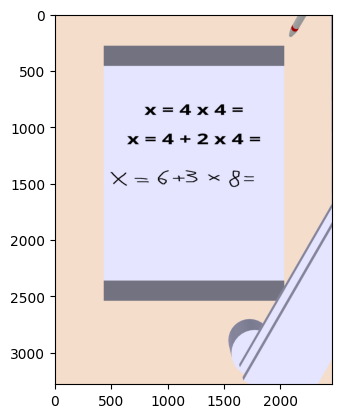

In [11]:
image = np.array(image)
image = image.astype(np.uint8)
img=np.array(abs(image),dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
img = cv2.flip(img, 1)                             # So it is not like a mirror
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img)
plt.show()

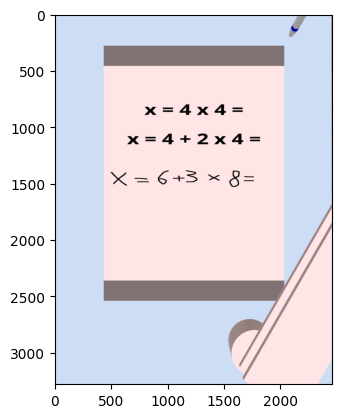

In [12]:
#CV library in Python can only work on BGR, GRAY or binarized images
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_BGR)
plt.show()

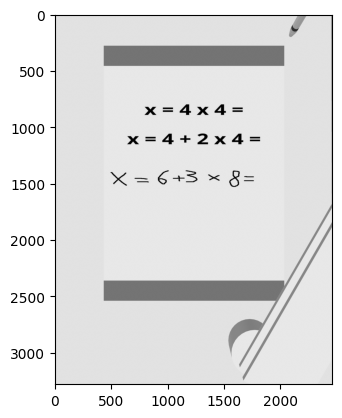

In [13]:
img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_GRAY, cmap='gray', vmin=0,vmax=255)
plt.show()

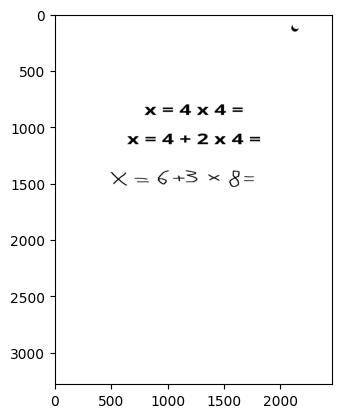

In [14]:
ret, thresh = cv2.threshold(img_GRAY,100,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray', vmin=0,vmax=255)
plt.show()

In [15]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [16]:
result = reader.readtext(thresh, paragraph=False, allowlist="0123456789+-x*/()=", width_ths=1.0)
result
#Retorna les coordenades dels quadres de text detectats, el text detectat i la confiança
#Cada quadre de text es defineix pels quatre punts que formen el rectangle al voltant del text
#L'ordre dels quatre punts és: Top-left corner, Top-right corner, Bottom-right corner, Bottom-left corner

[([[np.int32(789), np.int32(786)],
   [np.int32(1675), np.int32(786)],
   [np.int32(1675), np.int32(912)],
   [np.int32(789), np.int32(912)]],
  'x=4x4=',
  np.float64(0.8762882808525174)),
 ([[np.int32(633), np.int32(1046)],
   [np.int32(1832), np.int32(1046)],
   [np.int32(1832), np.int32(1174)],
   [np.int32(633), np.int32(1174)]],
  'x=4+2*4=',
  np.float64(0.6975536163286696)),
 ([[np.int32(500), np.int32(1374)],
   [np.int32(1781), np.int32(1374)],
   [np.int32(1781), np.int32(1536)],
   [np.int32(500), np.int32(1536)]],
  'x=6+3*8',
  np.float64(0.9227323180929521))]

In [17]:
recognized_texts = [item[1] for item in result]
recognized_texts

['x=4x4=', 'x=4+2*4=', 'x=6+3*8']

In [18]:
def convert_x(operacion):
    """
    Convierte las X en * si se trata de multiplicacion
    """
    operacion = operacion.replace(' ', '')  # Limpiar espacios
    nueva_operacion = []
    i = 0
    n = len(operacion)
    
    while i < n:
        if operacion[i] == 'x':
            # Caso 1: 'x=' → Es variable (ej: "x=4")
            if i + 1 < n and operacion[i+1] == '=':
                nueva_operacion.append('x=')  # Variable
                i += 1
            # Caso 2: 'x' entre números → Multiplicación (ej: "4x4")
            elif (i > 0 and operacion[i-1].isdigit()) and (i + 1 < n and operacion[i+1].isdigit()):
                nueva_operacion.append('*')  # Multiplicación
            else:
                nueva_operacion.append('x=')  # Por defecto, variable
        else:
            nueva_operacion.append(operacion[i])
        i += 1
    
    return ''.join(nueva_operacion)

expressions = []
for operacion in recognized_texts:
    expressions.append(convert_x(operacion))
expressions

['x=4*4=', 'x=4+2*4=', 'x=6+3*8']

In [19]:
def filter_expressions(expressions):
    """
    Filters out everything from the strings that isn't a number or an operator (+, -, *, /).

    Parameters:
    - expressions: List of strings containing mathematical expressions.

    Returns:
    - A list of filtered expressions containing only numbers and operators.
    """
    # Define valid characters (numbers and operators)
    valid_chars = "0123456789+-*/"

    # Filter each expression
    filtered_expressions = []
    for expr in expressions:
        # Build a new string with only valid characters
        filtered_expr = ''.join(char for char in expr if char in valid_chars)
        filtered_expressions.append(filtered_expr)

    return filtered_expressions

operacions = filter_expressions(expressions)
operacions

['4*4', '4+2*4', '6+3*8']

In [20]:
answers = []
for operacio in operacions:
    answers.append(eval(operacio))
answers

[16, 12, 30]

In [21]:
#Calcular punt de partida per escriure el resultat
textbox_coordinates=[item[0] for item in result]
start_coordinates=[item[1] for item in textbox_coordinates]
start_coordinates

[[np.int32(1675), np.int32(786)],
 [np.int32(1832), np.int32(1046)],
 [np.int32(1781), np.int32(1374)]]

In [22]:
#Calcular posicio en la escena
# X en la imatge es Y en el Coppelia i viceversa
coppelia_start_coordinates = []
# Dimensions plataforma en coppelia: 0.45 x 0.35
# Resolució imatge: 3280 x 2464
scale_factor = 0.45/3280
for point in start_coordinates:
    coppelia_start_coordinates.append([point[1]*scale_factor, point[0]*scale_factor+0.01])
print(coppelia_start_coordinates)

[[np.float64(0.10783536585365855), np.float64(0.23980182926829272)], [np.float64(0.14350609756097563), np.float64(0.26134146341463416)], [np.float64(0.18850609756097564), np.float64(0.254344512195122)]]


In [23]:
res, base_position = sim.simxGetObjectPosition(clientID, joint1, -1, sim.simx_opmode_blocking)
res, base_orientation = sim.simxGetObjectOrientation(clientID, joint1, -1, sim.simx_opmode_blocking)

In [24]:
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d = dynamicsymbols('theta1 theta2 d3 lc la lb theta alpha a d')
def euler_to_rotation_matrix(euler_angles):
    """
    Convert Euler angles (alpha, beta, gamma) to a 3x3 rotation matrix.
    """
    alpha, beta, gamma = euler_angles
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])
    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                   [np.sin(gamma), np.cos(gamma), 0],
                   [0, 0, 1]])
    return np.dot(Rz, np.dot(Ry, Rx))

In [25]:
# Transform the target position to the robot's local frame
x_global, y_global = coppelia_start_coordinates[0]
target_local = [x_global - base_position[0]-0.0428, y_global - base_position[1]+0.0491, 0.0255 - base_position[2]] # Subtract the base position

# Apply the inverse rotation (if the base is rotated)
R = euler_to_rotation_matrix(base_orientation)
target_local = np.dot(np.linalg.inv(R), target_local)

In [26]:
target_local

array([ 0.32496462, -0.04890186, -0.0695    ])

In [27]:
def resolveEquation(pos):
# we prepare the equations by transforming the expressions
# from the form <expression = value> to the form <expression - value> = 0
# We define a destination point of the Green piece
    # eq1 is the one that gives us the value of the position X (eq=f(x)-x=0)
    x = pos[0]
    y = pos[1]
    z = pos[2]
    eq1 = 0.2 * cos(theta1) + 0.2 * cos(theta1 + theta2) - x
    # eq2 is the one that gives us the value of the position Y (eq=f(y)-y=0)
    eq2 = (0.2 * sin(theta1) + 0.2 * sin(theta1 + theta2)) - y
    # eq3 is the one that gives us the value of the position Z (eq=f(z)-z=0)   0.108 is the real height of manipulator
    eq3 = 0.08 - d3 - z
    try:
        q = nsolve((eq1, eq2,eq3), (theta1, theta2, d3), (0.2,0.2,0.2), tol=1e-4)
    except Exception as e:
        print(f"No solution found: {e}")
        q = [0, 0, 0]
    
    return q

def getPositionMove(position):
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, position[0], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, position[1], sim.simx_opmode_oneshot)

def movePeg(peg):
    if peg == 1:
        q3 = 5 * np.pi/180
        returnCode = sim.simxSetJointTargetPosition(clientID, joint3, q3, sim.simx_opmode_oneshot)
    else:
        q3 = 10 * np.pi/180
        returnCode = sim.simxSetJointTargetPosition(clientID, joint3, q3, sim.simx_opmode_oneshot)
    return returnCode

In [28]:
# We solve the equations
q = resolveEquation(target_local)
q

Matrix([
[-0.756051913089742],
[  1.21336159595839],
[ 0.149499998807907]])

In [29]:
# We move the Scara
getPositionMove(q)

In [30]:
#Write numbers

# Function to generate trajectories for numbers 0-9
def get_number_trajectory(number, start_x, start_y, scale=0.02):
    """
    Generate a trajectory for a given number.

    Parameters:
    - number: The number to write (0-9).
    - start_x, start_y: Starting position of the number.
    - scale: Scaling factor for the size of the number.

    Returns:
    - A list of (x, y) points representing the trajectory.
    """
    # Define relative points for each number (normalized to [-0.5, 0.5])
    number_trajectories = {
        0: [(0.5, 0), (0.5, 0.5), (-0.5, 0.5), (-0.5, 0), (0.5, 0)],
        1: [(-0.5, 0), (0.5, 0)],
        2: [(0.5, 0.5), (0.5, 0), (0, 0), (0, 0.5), (-0.5, 0.5), (-0.5, 0)],
        3: [(0.5, 0.5), (0.5, 0), (0, 0), (0, 0.5), (0, 0), (-0.5, 0), (-0.5, 0.5)],
        4: [(0.5, 0.5), (0, 0.5), (0, 0), (0.5, 0), (-0.5, 0)],
        5: [(0.5, 0), (0.5, 0.5), (0, 0.5), (0, 0), (-0.5, 0), (-0.5, 0.5)],
        6: [(0.5, 0), (0.5, 0.5), (-0.5, 0.5), (-0.5,0), (0,0), (0,0.5)],
        7: [(0.5, 0.5), (0.5, 0), (-0.5, 0)],
        8: [(0.5, 0.5), (-0.5, 0.5), (-0.5, 0), (0.5, 0), (0.5, 0.5), (0.5, 0), (0, 0), (0,0.5)],
        9: [(-0.5, 0), (0.5, 0), (0.5, 0.5), (0, 0.5), (0, 0)]
    }
    """ 8 Segment coordinates
    0.5,0.5 - 0.5,0
    0,0.5   - 0,0
    -0.5,0.5 - -0.5,0
    """
    # Get the trajectory for the given number
    if number not in number_trajectories:
        raise ValueError("Invalid number. Must be between 0 and 9.")
    
    # Scale and translate the trajectory
    trajectory = [[start_x + x * scale, start_y + y * scale, -0.06945] for x, y in number_trajectories[number]]
    return trajectory

movePeg(0)
time.sleep(2)
answer_string=str(answers[0])
counter = 0
for number in answer_string:
    trajectory = get_number_trajectory(int(number), target_local[0], target_local[1])
    primerPunt=True
    time.sleep(1)
    for point in trajectory:
        if primerPunt:
            movePeg(0)
            primerPunt=False
        else:
            movePeg(1)
        time.sleep(1)
        point[1]-=counter*0.025
        print(point)
        q = resolveEquation(point)
        getPositionMove(q)
        
        time.sleep(1)
    time.sleep(1)
    movePeg(0)
    counter+=1
    time.sleep(3)
    

[np.float64(0.3149646155660911), np.float64(-0.04890186304202102), -0.06945]
[np.float64(0.33496461556609114), np.float64(-0.04890186304202102), -0.06945]
[np.float64(0.33496461556609114), np.float64(-0.07390186304202102), -0.06945]
[np.float64(0.33496461556609114), np.float64(-0.06390186304202103), -0.06945]
[np.float64(0.3149646155660911), np.float64(-0.06390186304202103), -0.06945]
[np.float64(0.3149646155660911), np.float64(-0.07390186304202102), -0.06945]
[np.float64(0.32496461556609113), np.float64(-0.07390186304202102), -0.06945]
[np.float64(0.32496461556609113), np.float64(-0.06390186304202103), -0.06945]
